In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.metrics import (mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


### 1. Run the feature engineering file to get the train, val, test set

[*********************100%***********************]  1 of 1 completed


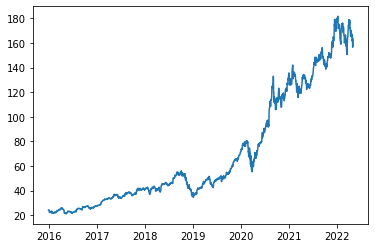

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1573 non-null   datetime64[ns]
 1   D_m3       1573 non-null   float64       
 2   D_m2       1573 non-null   float64       
 3   D_m1       1573 non-null   float64       
 4   Adj Close  1573 non-null   float64       
 5   bb_m1      1573 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 73.9 KB
           Date
0    2016-02-02
1    2016-02-03
2    2016-02-04
3    2016-02-05
4    2016-02-08
...         ...
1567 2022-04-22
1568 2022-04-25
1569 2022-04-26
1570 2022-04-27
1571 2022-04-28

[1572 rows x 1 columns]
         bb_m1      D_m3      D_m2      D_m1
0    -0.105413  0.007172  0.034541 -0.009349
1    -0.134902  0.034541 -0.009349 -0.020222
2    -0.108551 -0.009349 -0.020222  0.019793
3    -0.060615 -0.020222  0.019793  0.008035
4     0.042267  

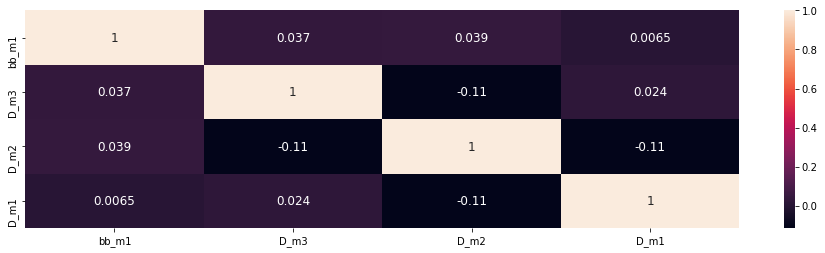

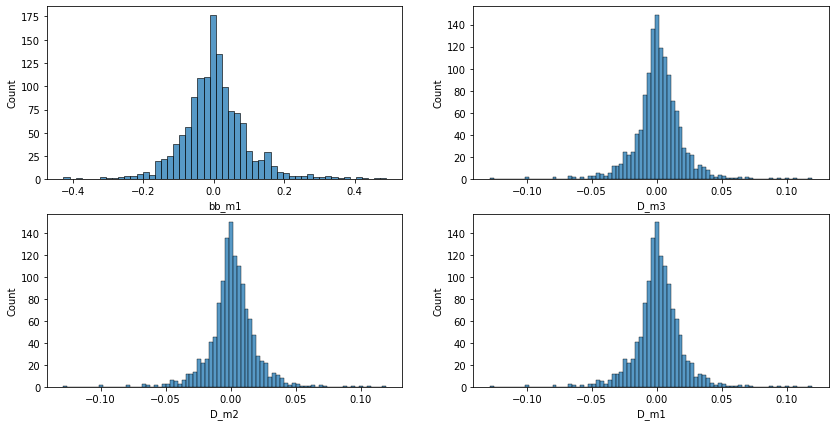

In [19]:
## Run below code to get data inclusive of Bband only with prices
%run DS105FP_ProjectScript_EdwinWan_1featureeng_final.ipynb

## Run below code to get data inclusive of MACD, MFI and BBand with prices
# %run DS105FP_ProjectScript_EdwinWan_1featureeng_initial.ipynb

### 2. Create the LSTM model (base)

In [20]:
#Create the LSTM model
model = Sequential([Input((x_train.shape[1],1)),
                    LSTM(64),
                    Dense(32,activation = 'relu'), 
                    # Dense(32,activation = 'relu'),
                    Dense(1)])
model.compile(loss = 'mse',
              optimizer = Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error'])
model.fit(x_train, y_train, validation_data=(x_val, y_val.reset_index(drop=True)), epochs=50)

Epoch 1/50
42/42 [==============================] - 7s 44ms/step - loss: 3.5732e-04 - mean_absolute_error: 0.0127 - val_loss: 1.6364e-04 - val_mean_absolute_error: 0.0101
Epoch 2/50
42/42 [==============================] - 1s 12ms/step - loss: 3.7110e-04 - mean_absolute_error: 0.0132 - val_loss: 1.3885e-04 - val_mean_absolute_error: 0.0092
Epoch 3/50
42/42 [==============================] - 0s 7ms/step - loss: 3.5745e-04 - mean_absolute_error: 0.0128 - val_loss: 1.4098e-04 - val_mean_absolute_error: 0.0092
Epoch 4/50
42/42 [==============================] - 0s 8ms/step - loss: 3.5816e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3972e-04 - val_mean_absolute_error: 0.0092
Epoch 5/50
42/42 [==============================] - 0s 7ms/step - loss: 3.5363e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4292e-04 - val_mean_absolute_error: 0.0093
Epoch 6/50
42/42 [==============================] - 0s 9ms/step - loss: 3.6082e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3970e-04 - val_mean_a

### 3. Create the dataset for previous day close price for the 3 sets. This is to calculate the predicted close price.

In [21]:
df_prev = df_train[['prev_close']]
df_prev

,prev_close
0,22.169813
1,21.721502
2,22.151426
3,22.329416
4,21.733036
...,...
1567,166.419998
1568,161.789993
1569,162.880005
1570,156.800003


In [22]:
prev_train, prev_val, prev_test = df_prev.loc[:pct_lm-1],df_prev.loc[pct_lm:pct_um-1], df_prev.loc[pct_um:]
prev_train, prev_val, prev_test

(      prev_close
 0      22.169813
 1      21.721502
 2      22.151426
 3      22.329416
 4      21.733036
 ...          ...
 1331  126.912170
 1332  125.737152
 1333  124.323151
 1334  124.163826
 1335  126.772774
 
 [1336 rows x 1 columns],
       prev_close
 1336  124.900703
 1337  126.563660
 1338  126.364502
 1339  126.314713
 1340  124.751335
 ...          ...
 1441  148.852829
 1442  149.072220
 1443  148.284393
 1444  148.234528
 1445  148.912674
 
 [110 rows x 1 columns],
       prev_close
 1446  148.443954
 1447  152.153809
 1448  149.391357
 1449  148.553650
 1450  149.610764
 ...          ...
 1567  166.419998
 1568  161.789993
 1569  162.880005
 1570  156.800003
 1571  156.570007
 
 [126 rows x 1 columns])

### 4. Predict pct_change, calculate the predicted price to compare with actual. Performance is also tested

- Predict and calculate predicted price and performance for train set

In [23]:
train_predictions = model.predict(x_train)
train_predictions

array([[ 2.8801283e-03],
       [ 4.9970201e-03],
       [ 1.1090571e-03],
       ...,
       [ 1.7073913e-03],
       [ 1.7231246e-03],
       [-9.4071962e-05]], dtype=float32)

In [24]:
pred_train = pd.DataFrame(train_predictions, columns=['pred_train'])
pred_train

,pred_train
0,0.002880
1,0.004997
2,0.001109
3,0.001543
4,0.002467
...,...
1331,-0.000344
1332,0.001408
1333,0.001707
1334,0.001723


In [25]:
df_compare = dates_train.merge(y_train, how='left', left_index=True, right_index=True)
df_compare = df_compare.merge(pred_train, how='left', left_index=True, right_index=True)
df_compare = df_compare.merge(prev_train, how='left', left_index=True, right_index=True)
df_compare['actual_close']=(df_compare['Adj Close']*df_compare['prev_close'])+df_compare['prev_close']
df_compare['pred_close']=(df_compare['pred_train']*df_compare['prev_close'])+df_compare['prev_close']
df_compare

,Date,Adj Close,pred_train,prev_close,actual_close,pred_close
0,2016-02-02,-0.020222,0.002880,22.169813,21.721502,22.233665
1,2016-02-03,0.019793,0.004997,21.721502,22.151426,21.830045
2,2016-02-04,0.008035,0.001109,22.151426,22.329416,22.175994
3,2016-02-05,-0.026708,0.001543,22.329416,21.733036,22.363866
4,2016-02-08,0.010530,0.002467,21.733036,21.961876,21.786654
...,...,...,...,...,...,...
1331,2021-05-17,-0.009259,-0.000344,126.912170,125.737152,126.868565
1332,2021-05-18,-0.011246,0.001408,125.737152,124.323151,125.914182
1333,2021-05-19,-0.001282,0.001707,124.323151,124.163826,124.535419
1334,2021-05-20,0.021012,0.001723,124.163826,126.772774,124.377776


In [26]:
rmse = np.sqrt(np.mean(df_compare['pred_close'] - df_compare['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare['actual_close'],df_compare['pred_close'])
r2 = r2_score(df_compare['actual_close'],df_compare['pred_close'])

print(f"The RMSE for train set is: {rmse}")
print(f"The MAPE for train set is: {mape}")
print(f"The R2 Score for test set is: {r2}")

The RMSE for train set is: 0.0006243788199200493
The MAPE for train set is: 0.012521996259550965
The R2 Score for test set is: 0.9981674206730988


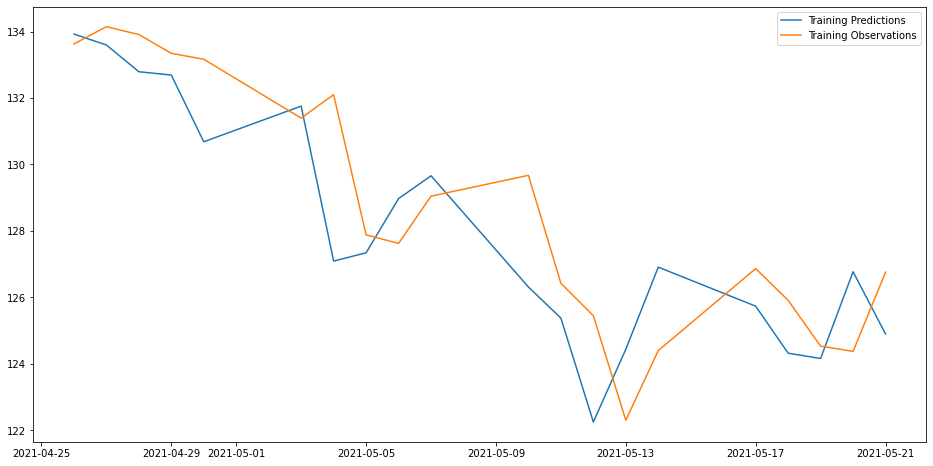

In [27]:
plt.figure(figsize=(16,8))
plt.plot(df_compare['Date'].tail(20), df_compare['actual_close'].tail(20))
plt.plot(df_compare['Date'].tail(20), df_compare['pred_close'].tail(20))
plt.legend(['Training Predictions', 'Training Observations'])



- Predict and calculate predicted price and performance for val set

In [28]:
val_predictions = model.predict(x_val)
pred_val = pd.DataFrame(val_predictions, columns=['pred_val'])


In [29]:
df_compare2 = dates_val.reset_index(drop=True).merge(y_val.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare2 = df_compare2.merge(pred_val, how='left', left_index=True, right_index=True)
df_compare2 = df_compare2.merge(prev_val.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare2['actual_close']=(df_compare2['Adj Close']*df_compare2['prev_close'])+df_compare2['prev_close']
df_compare2['pred_close']=(df_compare2['pred_val']*df_compare2['prev_close'])+df_compare2['prev_close']
df_compare2

,Date,Adj Close,pred_val,prev_close,actual_close,pred_close
0,2021-05-24,0.013314,0.002674,124.900703,126.563660,125.234633
1,2021-05-25,-0.001574,0.001479,126.563660,126.364502,126.750810
2,2021-05-26,-0.000394,0.002986,126.364502,126.314713,126.741854
3,2021-05-27,-0.012377,0.002850,126.314713,124.751335,126.674710
4,2021-05-28,-0.005348,0.004553,124.751335,124.084167,125.319378
...,...,...,...,...,...,...
105,2021-10-21,0.001474,-0.001271,148.852829,149.072220,148.663679
106,2021-10-22,-0.005285,-0.000352,149.072220,148.284393,149.019686
107,2021-10-25,-0.000336,0.001115,148.284393,148.234528,148.449709
108,2021-10-26,0.004575,0.000716,148.234528,148.912674,148.340646


In [30]:
rmse = np.sqrt(np.mean(df_compare2['pred_close'] - df_compare2['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare2['actual_close'],df_compare2['pred_close'])
r2 = r2_score(df_compare2['actual_close'],df_compare2['pred_close'])

print(f"The RMSE for validation set is: {rmse}")
print(f"The MAPE for validation set is: {mape}")
print(f"The R2 Score for validation set is: {r2}")

The RMSE for validation set is: 0.04999324322607648
The MAPE for validation set is: 0.009203255557549576
The R2 Score for validation set is: 0.9593105459407781


- Predict and calculate predicted price and performance for test set

In [31]:
test_predictions = model.predict(x_test)
pred_test = pd.DataFrame(test_predictions, columns=['pred_test'])

In [32]:
df_compare3 = dates_test.reset_index(drop=True).merge(y_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(pred_test, how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(prev_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3['actual_close']=(df_compare3['Adj Close']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3['pred_close']=(df_compare3['pred_test']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3

,Date,Adj Close,pred_test,prev_close,actual_close,pred_close
0,2021-10-28,0.024992,0.001073,148.443954,152.153809,148.603177
1,2021-10-29,-0.018156,-0.002129,152.153809,149.391357,151.829877
2,2021-11-01,-0.005607,0.002132,149.391357,148.553650,149.709926
3,2021-11-02,0.007116,0.003078,148.553650,149.610764,149.010845
4,2021-11-03,0.009799,0.001842,149.610764,151.076767,149.886340
...,...,...,...,...,...,...
121,2022-04-22,-0.027821,0.001013,166.419998,161.789993,166.588509
122,2022-04-25,0.006737,0.002313,161.789993,162.880005,162.164231
123,2022-04-26,-0.037328,0.000850,162.880005,156.800003,163.018526
124,2022-04-27,-0.001467,0.002885,156.800003,156.570007,157.252354


In [33]:
rmse = np.sqrt(np.mean(df_compare3['pred_close'] - df_compare3['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare3['actual_close'],df_compare3['pred_close'])
r2 = r2_score(df_compare3['actual_close'],df_compare3['pred_close'])

print(f"The RMSE for test set is: {rmse}")
print(f"The MAPE for test set is: {mape}")
print(f"The R2 Score for test set is: {r2}")

The RMSE for test set is: 0.10469828937377608
The MAPE for test set is: 0.014831565709000264
The R2 Score for test set is: 0.8750962251924167


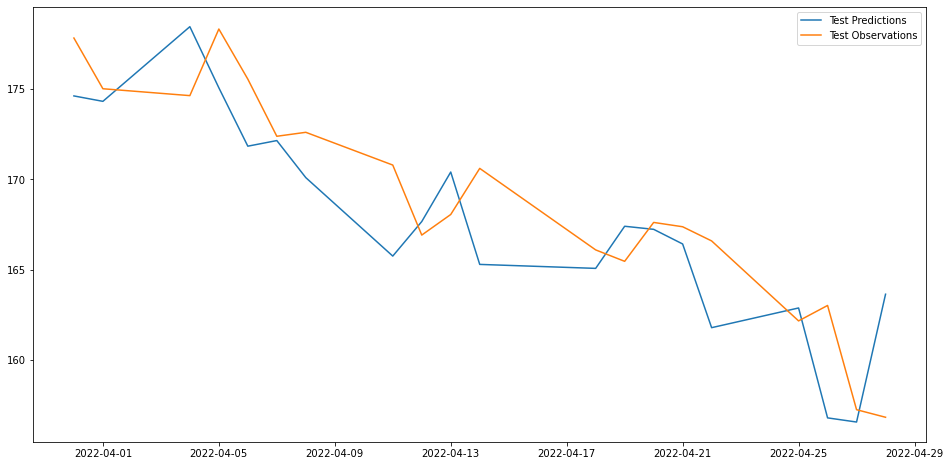

In [34]:
plt.figure(figsize=(16,8))
plt.plot(df_compare3['Date'].tail(20), df_compare3['actual_close'].tail(20))
plt.plot(df_compare3['Date'].tail(20), df_compare3['pred_close'].tail(20))
plt.legend(['Test Predictions', 'Test Observations'])